In [1]:
%matplotlib inline

import os, glob, sys, time, random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
from torch.autograd import Variable
from torchvision.utils import save_image
import torch.optim as optim
from torch.utils import data

import phate
import scanpy as sc


import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
from scipy import stats

import tifffile 
from PIL import Image


In [2]:
# filepaths

idfp = '/home/ngr4/project/zfish/data/tifs'
pfp = '/home/ngr4/project/zfish/results/cnn'
pdfp = '/home/ngr4/project/zfish/data/processed'
tfp = '/home/ngr4/project/zfish/data/cifar10/'


# filenames for images
tif_files = glob.glob(os.path.join(idfp,'*.tif'))

# aesthetics
plt.rc('text',usetex=True)

In [3]:
# utils 

def parse_filenames(file_list, n_test=5, verbose=True) : 
    '''Train/test split for 3 timepoint classes'''
    dpf3 = []
    dpf4 = []
    dpf5 = []
    count = 0
    for f in file_list : 
        if '3dpf' in f :
            dpf3.append(f)
        elif '4dpf' in f :
            dpf4.append(f)
        elif '5dpf' in f :
            dpf5.append(f)
        else :
            count+=1
            print('{} files in data folder not matched.\n...Problem file: {}'.format(count,f))
            
    if verbose :
        print('\n3dpf has {}-images'.format(len(dpf3)))
        print('4dpf has {}-images'.format(len(dpf4)))
        print('5dpf has {}-images\n'.format(len(dpf5)))
            
    dpf3_test = random.sample(dpf3,n_test)
    dpf3_train= [i for i in dpf3 if i not in dpf3_test] 
    dpf4_test = random.sample(dpf4,n_test)
    dpf4_train= [i for i in dpf4 if i not in dpf4_test] 
    dpf5_test = random.sample(dpf5,n_test)
    dpf5_train= [i for i in dpf5 if i not in dpf5_test] 
    
    if verbose :
        # for reproducibility, hard code test set op to get train
        print('3 DPF test set...')
        for i in dpf3_test :
            print('    {}'.format(os.path.split(i)[1].split('.npy')[0]))
        print('\n4 DPF test set...')
        for i in dpf4_test :
            print('    {}'.format(os.path.split(i)[1].split('.npy')[0]))
        print('\n5 DPF test set...')
        for i in dpf5_test :
            print('    {}'.format(os.path.split(i)[1].split('.npy')[0]))
            
    return dpf3_train,dpf4_train,dpf5_train,dpf3_test,dpf4_test,dpf5_test

def get_im(fname) : 
    '''returns numpy array on range [0,1]'''
    img = tifffile.imread(fname) 
    if len(img.shape)>2 : #Cxy
        # 2-channel image, 2nd channel has vasculature
        img = img[1,:,:]
    img = img/(2**12 - 1)
    img = img/np.mean(img)
    img = img/20
    img[img>1] = 1
#     img = (img - np.mean(img))/np.std(img) # z-score
#     img = img/np.mean(img)
#     img = img/np.max(img) # scale [0,1]
    return img

def accuracy() :
    '''TODO (unless doing regression)'''
    return None
            
    

In [4]:
# train/test split
d3,d4,d5,d3_test,d4_test,d5_test=parse_filenames(tif_files)
train_files = d3+d4+d5
test_files = d3_test+d4_test+d5_test


3dpf has 49-images
4dpf has 54-images
5dpf has 53-images

3 DPF test set...
    kdrgfp3dpfDec16th2019_Series007_MIP.tif
    kdrgfp3dpfNov25th2019_Series001_MIP.tif
    kdrgfp3dpfNov25th2019_Series006_MIP.tif
    kdrgfp3dpfNov25th2019_Series002_MIP.tif
    kdrgfp3dpfNov25th2019_Series008_MIP.tif

4 DPF test set...
    kdrgfp4dpfDec17th2019_Series008_MIP.tif
    Notch3kdrmChpdgfrbeGFP4dpfDec3rd2019_Series003Het_MIP.tif
    Notch3kdrmChpdgfrbeGFP4dpfJan14th2020_Series002WT_MIP.tif
    kdrgfp4dpfNov26th2019_Series007_MIP.tif
    kdrgfp4dpfDec17th2019_Series011_MIP.tif

5 DPF test set...
    Notch3kdrmChpdgfrbeGFP5dpfJan15th2020_Series010Het_MIP.tif
    Notch3kdrmChpdgfrbeGFP5dpfJan15th2020_Series007Het_MIP.tif
    kdrgfp5dpfDec18th2019_Series007_MIP.tif
    kdrgfp5dpfNov27th2019_Series011_MIP.tif
    Notch3kdrmChpdgfrbeGFP5dpfJan15th2020_Series004Mut_MIP.tif


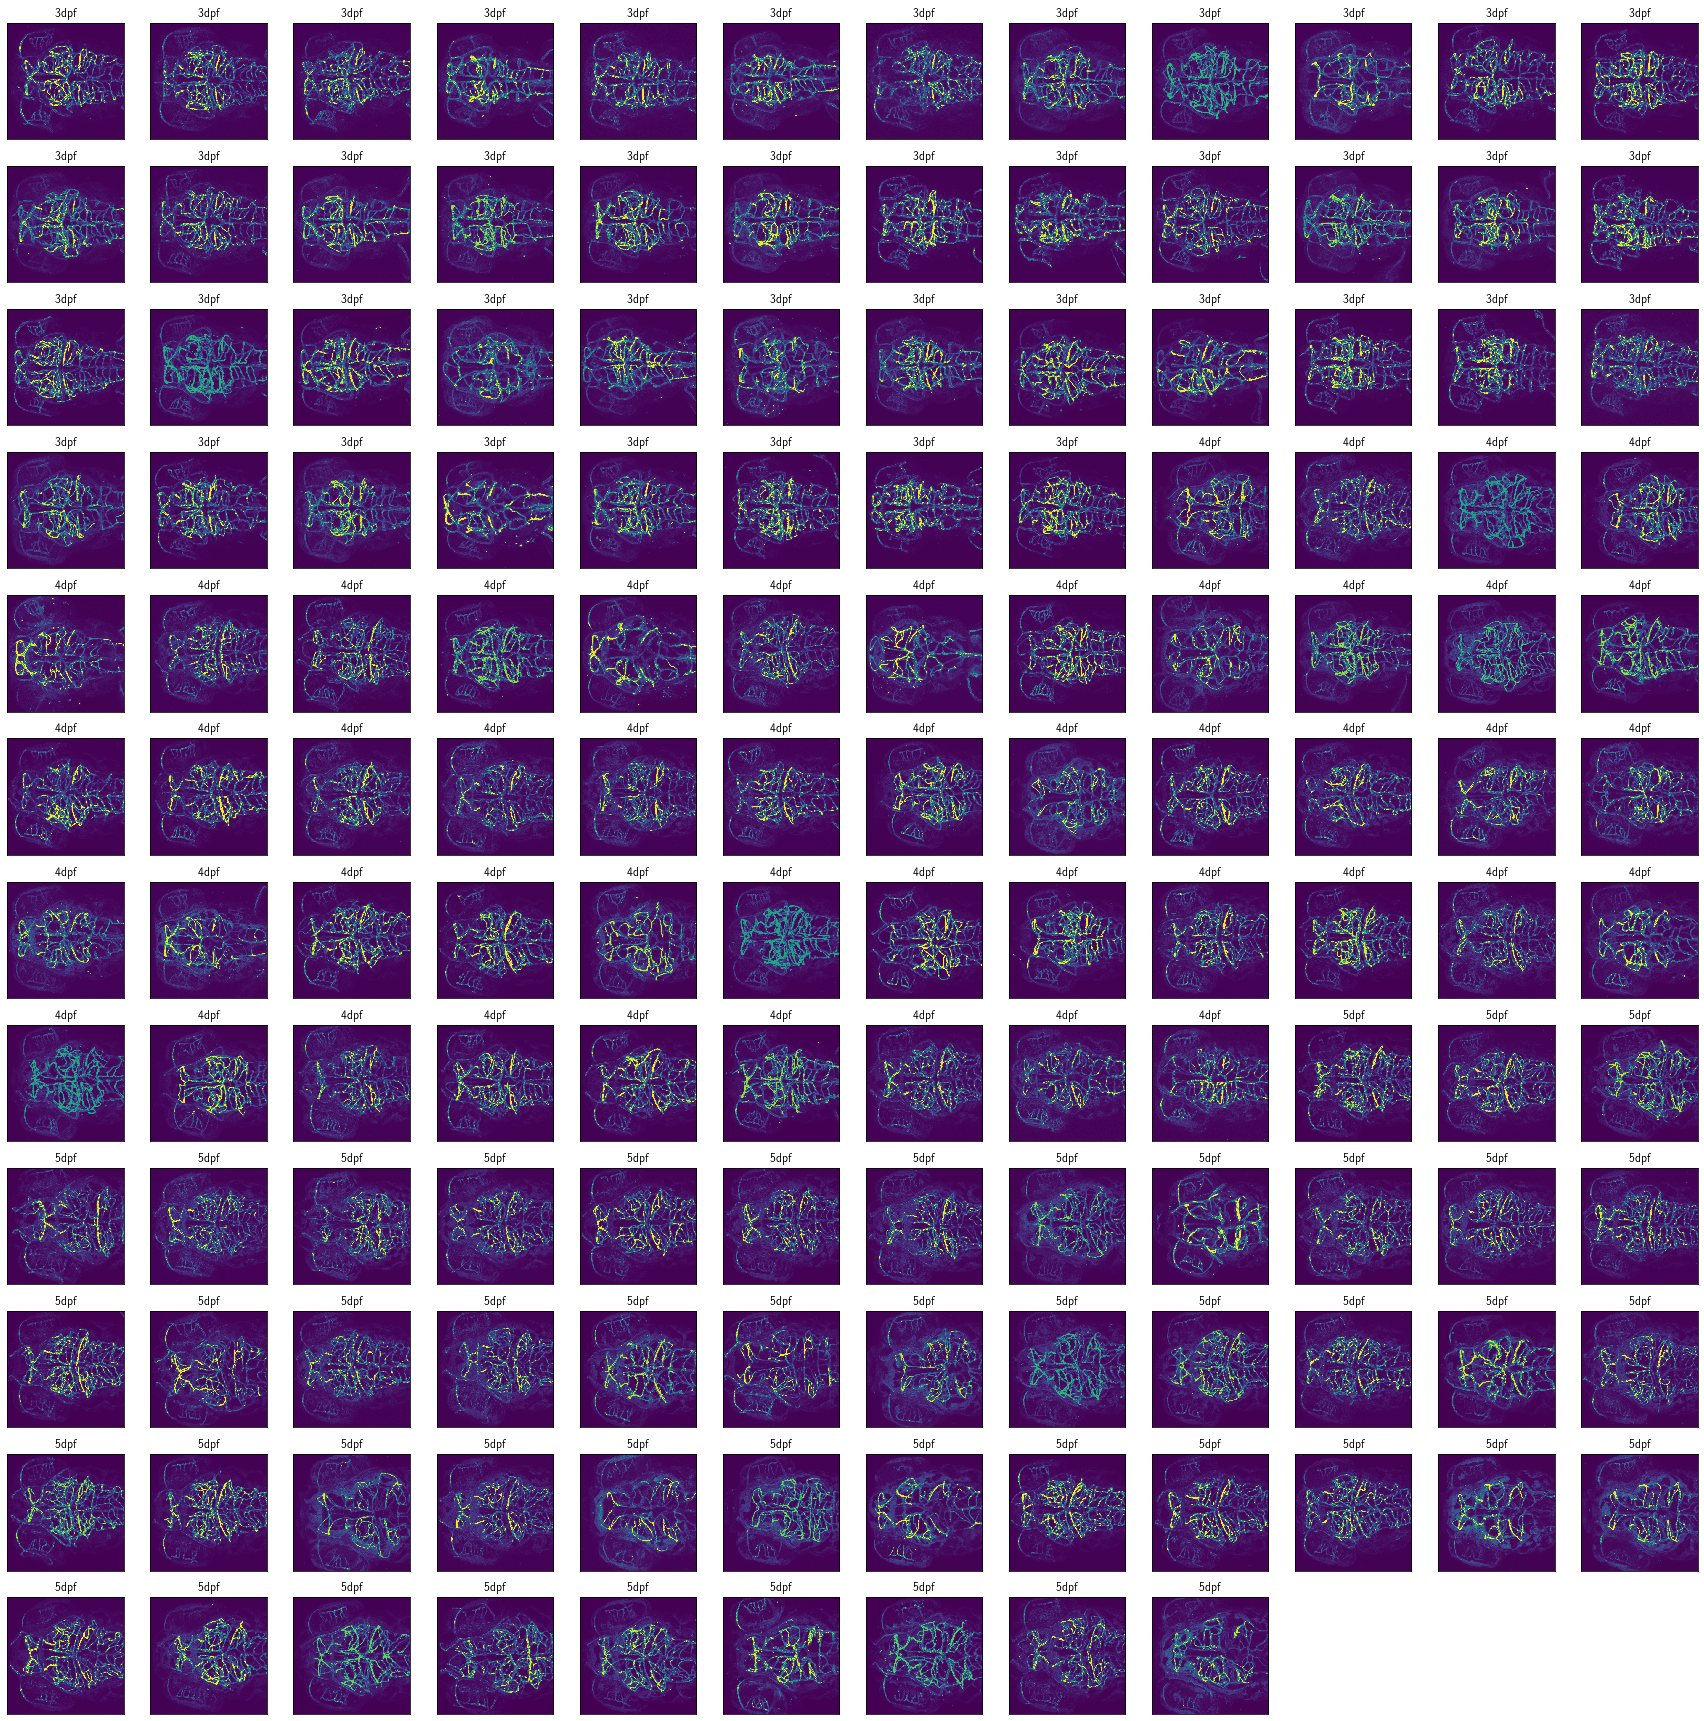

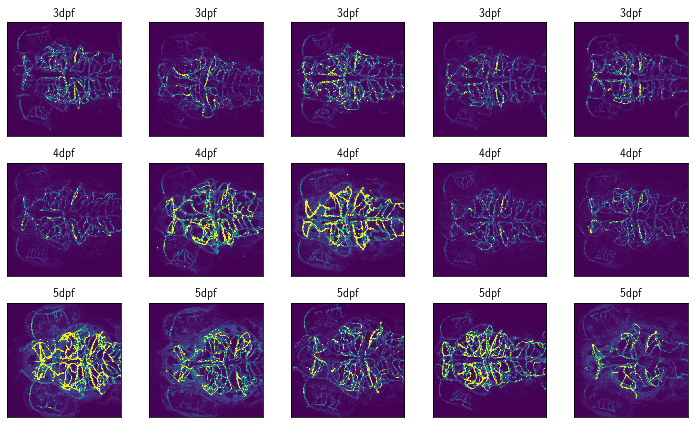

In [5]:
# visualize data

# train
fig = plt.figure(figsize=(24,26))
for i,file in enumerate(train_files) : 
    ax=fig.add_subplot(13,12,i+1)
    img = get_im(file)
    ax.imshow(img, vmin=0, vmax=0.5)
    f = os.path.split(file)[1].split('.tif')[0]
    if '3dpf' in f :
        label = '3dpf'
    elif '4dpf' in f :
        label = '4dpf'
    elif '5dpf' in f :
        label = '5dpf'
    ax.set_title(label)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout()
    
    
# train
fig = plt.figure(figsize=(10,6))
for i,file in enumerate(test_files) : 
    ax=fig.add_subplot(3,5,i+1)
    img = get_im(file)
    ax.imshow(img)
    f = os.path.split(file)[1].split('.tif')[0]
    if '3dpf' in f :
        label = '3dpf'
    elif '4dpf' in f :
        label = '4dpf'
    elif '5dpf' in f :
        label = '5dpf'
    ax.set_title(label)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout()
    

In [6]:
# data loader for sampling 

class zfish(data.Dataset):
    '''List of files to be used for torch generation of image batches'''
    
    def __init__(self, files, transform=None, addNoise=False):
        self.files = files
        self.transform = transform
        self.addNoise=addNoise

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.files)

    def __getitem__(self, idx):
        'Generates one sample of data'
        
        # select sample
        file = self.files[idx]
        f = os.path.split(file)[1].split('.tif')[0]

        # load data
        img = get_im(file)
        
        # noise?
        if self.addNoise :
            img = img + np.random.normal(0,0.1,[img.shape[0],img.shape[0]])
            img = (img - np.min(img)) / (np.max(img) - np.min(img)) # range [0,1]
        
        # convert to PIL image
        img = Image.fromarray(img)

        # transform
        if self.transform :
            img = self.transform(img)

        # label (regression task => number given)
        if '3dpf' in f :
            target = -0.5
        elif '4dpf' in f :
            target = 0.0
        elif '5dpf' in f :
            target = 0.5
        else : 
            print('target mismatch for {}'.format(f))

        return img, target

In [7]:
# load data 

if False :
    # check num_workers available
    import multiprocessing
    pool = multiprocessing.Pool()
    print(pool._processes)

# hyperparams
batch_size_train = 32
batch_size_test = 5
transform = tv.transforms.Compose(
    [tv.transforms.Resize((128,128)), # bilinear interpolation?
     tv.transforms.ToTensor(),
     tv.transforms.Normalize((0.5,),(0.5,))])


# generators
training_set = zfish(train_files, transform=transform, addNoise=True)
training_generator = data.DataLoader(training_set, 
                                     batch_size=batch_size_train,
                                     shuffle=True,
                                     num_workers=20)
validation_set = zfish(test_files, transform=transform)
validation_generator = data.DataLoader(validation_set,
                                       batch_size=batch_size_test,
                                       shuffle=True,
                                       num_workers=20)



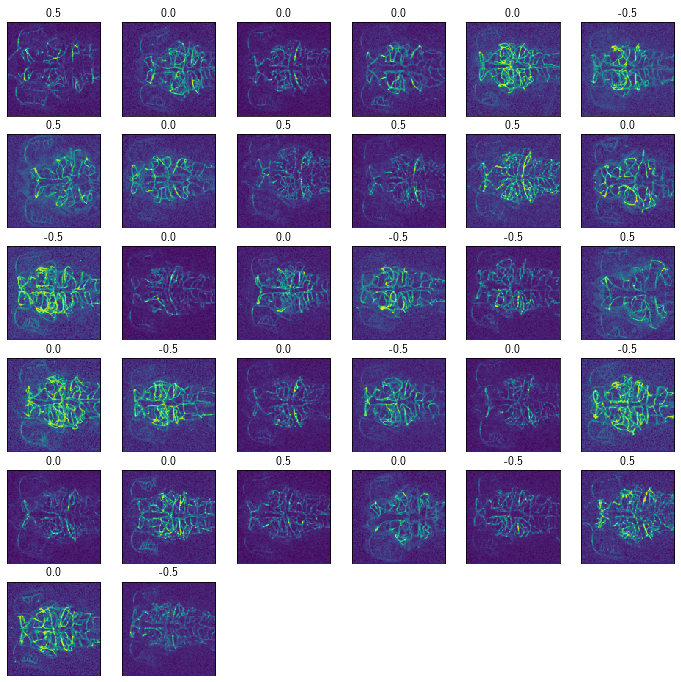

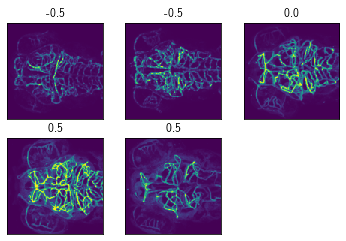

In [8]:
# visualize data

# train
dataiter = iter(training_generator)
images, labels = dataiter.next()

n_=np.ceil(np.sqrt(batch_size_train))

fig = plt.figure(figsize=(int(n_*2),int(n_*2)))
for i in range(images.shape[0]) :
    ax=fig.add_subplot(int(n_),int(n_),i+1)
    ax.imshow(images[i,0,:,:])
    ax.set_title(labels[i].numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
# test
dataiter = iter(validation_generator)
images, labels = dataiter.next()

n_=np.ceil(np.sqrt(batch_size_test))

fig = plt.figure(figsize=(int(n_*2),int(n_*2)))
for i in range(images.shape[0]) :
    ax=fig.add_subplot(int(n_),int(n_),i+1)
    ax.imshow(images[i,0,:,:])
    ax.set_title(labels[i].numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


In [9]:
# model

class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, 
                               out_channels=4, 
                               kernel_size=5,
                               stride=1,
                               padding=0)
        
        self.pool = nn.MaxPool2d(kernel_size=2, 
                                 stride=2,
                                 padding=0)
        
        self.pool3 = nn.MaxPool2d(kernel_size=1,
                                  stride=2,
                                  padding=0)
        
        self.conv2 = nn.Conv2d(in_channels=4, 
                               out_channels=8, 
                               kernel_size=5,
                               stride=1,
                               padding=0)
        
        self.conv3 = nn.Conv2d(in_channels=8, 
                               out_channels=16, 
                               kernel_size=5,
                               stride=1,
                               padding=0)
        
        self.fc1 = nn.Linear(in_features=16 * 13 * 13, 
                             out_features=100,
                             bias=True)
        
        self.fc2 = nn.Linear(in_features=100, 
                             out_features=25,
                             bias=True)
        
        self.fc3 = nn.Linear(in_features=25, 
                             out_features=1, # number of classes
                             bias=True)
        
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x))) # 128 --> 124 --> 62
        x = self.pool(F.leaky_relu(self.conv2(x))) # 62 --> 58 --> 29
        x = self.pool3(F.leaky_relu(self.conv3(x))) # 29 --> 25 --> 13
        x = x.view(-1, 16 * 13 * 13) # reshape
        x = F.leaky_relu(self.fc1(x))
        if True :
            x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = x.squeeze() # kick out extra dim
        return x


In [10]:
# train

total = time.time()

# initialize model
model = cnn()

# hyperparameters
n_epoch = 100
learning_rate = 0.001 # (default) lr=0.001
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # change to AdaGrad

# save losses
train_losses = []
test_losses = []

for epoch in range(n_epoch):  # loop over the dataset multiple times
    train_loss_epoch = []
    test_loss_epoch = []
    
    start = time.time()
    running_loss = 0.0
    for i, d in enumerate(training_generator):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = d

        # zero the parameter gradients
        model.train()
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs.double(), labels.double())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        # evaluate on test set
        test_loss = 0
        model.eval()
        with torch.no_grad() :
            dataiter = iter(validation_generator)
            inputs_val,labels_val = dataiter.next()
            outputs_val = model(inputs_val)
            batch_loss = criterion(outputs_val.double(),labels_val.double())
            test_loss += batch_loss.item()
        test_loss_epoch.append(test_loss)
        train_loss_epoch.append(running_loss)
        
        print('Epoch {:4d},batch {:3d}\ttrain_loss:{:.6f}\ttest_loss:{:.6f}'.format(epoch+1,i+1,running_loss,test_loss))
        running_loss = 0.0
    
    # average losses, add to overall train/test loss
    ave_train_loss=np.sum(train_loss_epoch)/len(train_loss_epoch)
    ave_test_loss=np.sum(test_loss_epoch)/len(test_loss_epoch)
    train_losses.append(ave_train_loss)
    test_losses.append(ave_test_loss)

    print('...Epoch {} in {:.2f}-s\t<train_loss>:{:.6f}\t<test_loss>:{:.6f}\n'.format(epoch+1,time.time() - start,ave_train_loss,ave_test_loss))
    
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch, i + 1, running_loss / 2000))
#             running_loss = 0.0

print("\nTraining finished in {:.2f}-min".format((time.time() - total)/60))

Epoch    1,batch   1	train_loss:0.163928	test_loss:0.200111
Epoch    1,batch   2	train_loss:0.173945	test_loss:0.143138
Epoch    1,batch   3	train_loss:0.132206	test_loss:0.258839
Epoch    1,batch   4	train_loss:0.165055	test_loss:0.141491
Epoch    1,batch   5	train_loss:0.198476	test_loss:0.193691
...Epoch 1 in 17.44-s	<train_loss>:0.166722	<test_loss>:0.187454

Epoch    2,batch   1	train_loss:0.171759	test_loss:0.143518
Epoch    2,batch   2	train_loss:0.143185	test_loss:0.155711
Epoch    2,batch   3	train_loss:0.168199	test_loss:0.234813
Epoch    2,batch   4	train_loss:0.164606	test_loss:0.099153
Epoch    2,batch   5	train_loss:0.141507	test_loss:0.097450
...Epoch 2 in 16.21-s	<train_loss>:0.157851	<test_loss>:0.146129

Epoch    3,batch   1	train_loss:0.157397	test_loss:0.137228
Epoch    3,batch   2	train_loss:0.130274	test_loss:0.094826
Epoch    3,batch   3	train_loss:0.148340	test_loss:0.133340
Epoch    3,batch   4	train_loss:0.129245	test_loss:0.100548
Epoch    3,batch   5	train_l

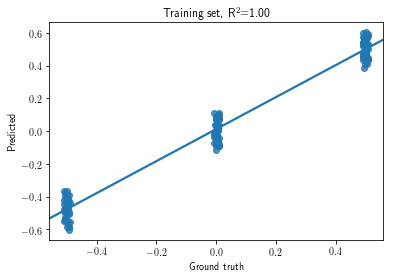

In [12]:
# overfit on train?
get_train = data.DataLoader(training_set, 
                            batch_size=len(training_set),
                            shuffle=False,
                            num_workers=20)
dataiter = iter(get_train)
images, labels = dataiter.next()
outputs = model(images).detach()
x_,y_=labels.numpy(),outputs.numpy()
ax = sns.regplot(x=x_,y=y_,x_jitter=0.01,y_jitter=0.1)
ax.set_ylabel('Predicted')
ax.set_xlabel('Ground truth')
slope, intercept, r_value, p_value, std_err = stats.linregress(x_, y_)
ax.set_title('Training set, R$^2$={:.2f}'.format(r_value**2))
fig = ax.get_figure()
if True :
    fig.savefig(os.path.join(pfp,'train_scatter.png'),dpi=600)

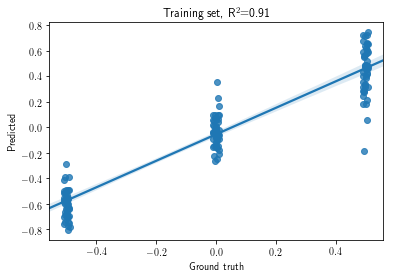

In [20]:
# overfit on train?
train_noNoise = zfish(train_files, transform=transform,addNoise=False)
get_train = data.DataLoader(train_noNoise, 
                            batch_size=len(train_noNoise),
                            shuffle=False,
                            num_workers=20)
dataiter = iter(get_train)
images, labels = dataiter.next()
outputs = model(images).detach()
x_,y_=labels.numpy(),outputs.numpy()
ax = sns.regplot(x=x_,y=y_,x_jitter=0.01,y_jitter=0.1)
ax.set_ylabel('Predicted')
ax.set_xlabel('Ground truth')
slope, intercept, r_value, p_value, std_err = stats.linregress(x_, y_)
ax.set_title('Training set, R$^2$={:.2f}'.format(r_value**2))
fig = ax.get_figure()
if True :
    fig.savefig(os.path.join(pfp,'train_scatter_noNoise.png'),dpi=600)

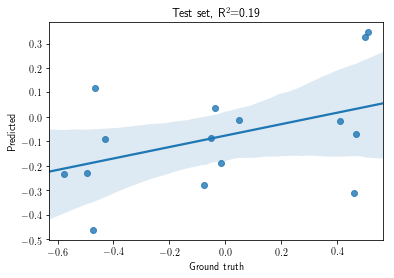

In [13]:
# performance on test?
test_set = zfish(test_files, transform=transform,addNoise=False)
get_test = data.DataLoader(test_set, 
                           batch_size=len(test_set),
                           shuffle=False,
                           num_workers=20)
dataiter = iter(get_test)
images, labels = dataiter.next()
outputs = model(images).detach()
x_,y_=labels.numpy(),outputs.numpy()
ax = sns.regplot(x=x_,y=y_,x_jitter=0.1)
ax.set_ylabel('Predicted')
ax.set_xlabel('Ground truth')
slope, intercept, r_value, p_value, std_err = stats.linregress(x_, y_)
ax.set_title('Test set, R$^2$={:.2f}'.format(r_value**2))

fig = ax.get_figure()
if True :
    fig.savefig(os.path.join(pfp,'test_scatter.png'),dpi=600)


Text(0.5, 0, 'Epoch')

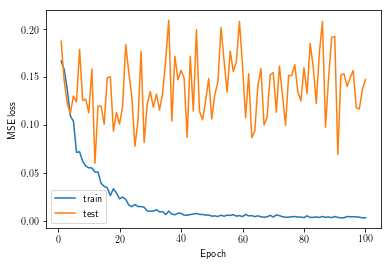

In [15]:
# plot losess (ave across batches)
loss = pd.DataFrame({'train':train_losses,
                     'test':test_losses,
                     'epoch':range(1,len(train_losses)+1)})
loss = pd.melt(loss,value_vars=['train','test'],id_vars=['epoch'])
ax = sns.lineplot(x='epoch',y='value',hue='variable',data=loss)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
ax.set_ylabel('MSE loss')
ax.set_xlabel('Epoch')

# Perturbations

In [146]:
# get all images
im_set = zfish(train_files+test_files, 
               transform=transform, addNoise=False)
data_generator = data.DataLoader(im_set, 
                                 batch_size=len(im_set),
                                 shuffle=False,
                                 num_workers=20)
dataiter = iter(data_generator)
images, labels = dataiter.next()

images = images.squeeze()


In [ ]:
output = np.zeros([images.shape[0],images.shape[1],images.shape[2]])
rand = np.random.uniform(low=-1,high=1,size=[images.shape[0],images.shape[1],images.shape[2]])
for i in range(images.shape[0]) : # per image
    start = time.time()
    for j in range(images.shape[1]) :
        for k in range(images.shape[2]) :
            r = rand[i,j,k]
            images[i,j,k] = r
            model.eval()
            preds = model(images[i,:,:].view(1,1,images.shape[1],images.shape[2])).detach().numpy()
            output[i,j,k] = preds
    print('Im {} out of {} randomized in {:.2f}-s'.format(i+1,images.shape[0],time.time()-start))

Im 1 out of 156 randomized in 36.97-s
Im 2 out of 156 randomized in 37.00-s
Im 3 out of 156 randomized in 37.14-s
Im 4 out of 156 randomized in 36.96-s
Im 5 out of 156 randomized in 36.98-s
Im 6 out of 156 randomized in 37.13-s
Im 7 out of 156 randomized in 37.01-s
Im 8 out of 156 randomized in 37.00-s
Im 9 out of 156 randomized in 35.58-s
Im 10 out of 156 randomized in 35.65-s
Im 11 out of 156 randomized in 35.54-s
Im 12 out of 156 randomized in 35.55-s
Im 13 out of 156 randomized in 35.55-s
Im 14 out of 156 randomized in 35.51-s
Im 15 out of 156 randomized in 35.41-s
Im 16 out of 156 randomized in 35.45-s
Im 17 out of 156 randomized in 35.66-s
Im 18 out of 156 randomized in 35.51-s
Im 19 out of 156 randomized in 35.58-s
Im 20 out of 156 randomized in 35.53-s
Im 21 out of 156 randomized in 35.75-s
Im 22 out of 156 randomized in 35.48-s
Im 23 out of 156 randomized in 35.48-s
Im 24 out of 156 randomized in 35.69-s
Im 25 out of 156 randomized in 35.55-s
Im 26 out of 156 randomized in 35.

In [154]:
# randomly sample
n_sample = 10
H,W=images.shape[1],images.shape[2]
output_samp = np.zeros([n_sample,H,W])
rand_samp = np.random.uniform(low=-1,high=1,size=[n_sample,H,W])
images_perturbed = images
for j in range(H) :
    start = time.time()
    for k in range(W) :
        r = rand_samp[np.arange(n_sample),j,k]
        randimg_idx = random.sample(range(images.shape[0]),n_sample)
        images_perturbed[randimg_idx,j,k] = torch.from_numpy(r).float()
        model.eval()
        preds = model(images[randimg_idx,:,:].view(n_sample,1,H,W)).detach().numpy()
        output_samp[np.arange(n_sample),j,k] = preds
    print('Finished Hth pixel row {} in {:.2f}-s'.format(j+1,time.time() - start))


Finished Hth pixel row 1 in 1.87-s
Finished Hth pixel row 2 in 1.85-s
Finished Hth pixel row 3 in 1.84-s
Finished Hth pixel row 4 in 1.84-s
Finished Hth pixel row 5 in 1.85-s
Finished Hth pixel row 6 in 1.86-s
Finished Hth pixel row 7 in 1.84-s
Finished Hth pixel row 8 in 1.85-s
Finished Hth pixel row 9 in 1.85-s
Finished Hth pixel row 10 in 1.85-s
Finished Hth pixel row 11 in 1.85-s
Finished Hth pixel row 12 in 1.85-s
Finished Hth pixel row 13 in 1.85-s
Finished Hth pixel row 14 in 1.86-s
Finished Hth pixel row 15 in 1.86-s
Finished Hth pixel row 16 in 1.86-s
Finished Hth pixel row 17 in 1.86-s
Finished Hth pixel row 18 in 1.86-s
Finished Hth pixel row 19 in 1.87-s
Finished Hth pixel row 20 in 1.87-s
Finished Hth pixel row 21 in 1.89-s
Finished Hth pixel row 22 in 2.02-s
Finished Hth pixel row 23 in 1.87-s
Finished Hth pixel row 24 in 1.87-s
Finished Hth pixel row 25 in 1.87-s
Finished Hth pixel row 26 in 1.88-s
Finished Hth pixel row 27 in 1.88-s
Finished Hth pixel row 28 in 1.87-s
F

Text(50.0, 0.5, '')

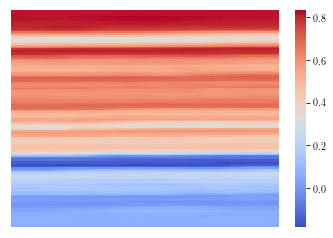

In [66]:
# correlate output per randomized pixel and truth
lab_array = np.ones([images.shape[0],images.shape[1],images.shape[2]]) * labels.view(labels.shape[0],1,1).numpy()
H,W = images.shape[1],images.shape[1] # px
corr = np.zeros([H,W])
# loop through px
for i in range(H) :
    for j in range(W) : 
        corr[i,j],_=stats.pearsonr(lab_array[:,i,j],output[:,i,j])

# plot 
# plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1)
p = sns.heatmap(corr,
                cmap='coolwarm',
                annot=False,
#                 fmt=".1f",
#                 annot_kws={'size':16},
                cbar_kws={"ticks":[]},
                ax=ax,
                xticklabels='',
                yticklabels='')
#                 vmax = 0.08,
#                 vmin=-0.08)
plt.xlabel('')
plt.ylabel('')
# plt.text(5,12.3, "Correlation of output with randomized pixel value, across image set", fontsize = 20, color='Black')


Text(50.0, 0.5, '')

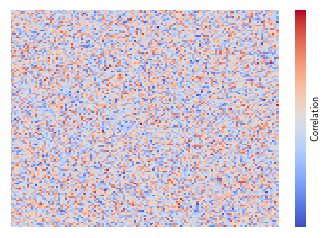

In [156]:
# correlate the perturbed values (perturbed pixels) with the output
H,W = images.shape[1],images.shape[1] # px
# lab_array = np.ones([images.shape[0],H,W]) * labels.view(labels.shape[0],1,1).numpy() # need to store in for loop if want this
rand_expand = np.ones([n_sample,H,W])*rand_samp
corr_samp = np.zeros([H,W])
# loop through px
for i in range(H) :
    for j in range(W) : 
        corr_samp[i,j],_=stats.pearsonr(rand_expand[:,i,j],output_samp[:,i,j])

# plot 
# plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1)
p = sns.heatmap(corr_samp,
                cmap='coolwarm',
                annot=False,
#                 fmt=".1f",
#                 annot_kws={'size':16},
                cbar_kws={'ticks':[],
                          'label':'Correlation'},
                ax=ax,
                xticklabels='',
                yticklabels='')
#                 vmax = 0.08,
#                 vmin=-0.08)
plt.xlabel('')
plt.ylabel('')
# plt.text(5,12.3, "Correlation of output with randomized pixel value, across image set", fontsize = 20, color='Black')


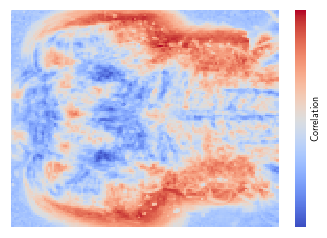

In [153]:
# correlate the unperturbed values (perturbed pixels) with the output
H,W = images.shape[1],images.shape[1] # px
lab_array = np.ones([images.shape[0],H,W]) * labels.view(labels.shape[0],1,1).numpy() # need to store in for loop if want this
# rand_expand = np.ones([n_sample,H,W])*rand_samp
corr_samp = np.zeros([H,W])
# loop through px
for i in range(H) :
    for j in range(W) : 
        corr_samp[i,j],_=stats.pearsonr(images[:,i,j],lab_array[:,i,j])

# plot 
# plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1)
p = sns.heatmap(corr_samp,
                cmap='coolwarm',
                annot=False,
#                 fmt=".1f",
#                 annot_kws={'size':16},
                cbar_kws={'ticks':[],
                          'label':'Correlation'},
                ax=ax,
                xticklabels='',
                yticklabels='')
#                 vmax = 0.08,
#                 vmin=-0.08)
plt.xlabel('')
plt.ylabel('')
fig.savefig(os.path.join(pfp,'corr_output_px.png'),dpi=600)

Text(50.0, 0.5, '')

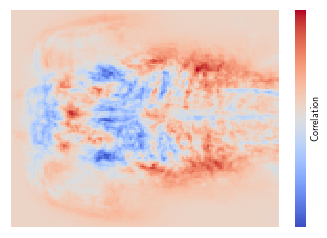

In [149]:
t3 = np.where(labels.numpy()==-0.5)[0]
t5 = np.where(labels.numpy()==0.5)[0]
dt3 = np.mean(images[t3,:,:].numpy(),axis=0)
dt5 = np.mean(images[t5,:,:].numpy(),axis=0)
diff_map = dt5 - dt3
fig, ax = plt.subplots(1)
p = sns.heatmap(diff_map,
                cmap='coolwarm',
                annot=False,
#                 fmt=".1f",
#                 annot_kws={'size':16},
                cbar_kws={'ticks':[],
                          'label':'Correlation'},
                ax=ax,
                xticklabels='',
                yticklabels='')
#                 vmax = 0.08,
#                 vmin=-0.08)
plt.xlabel('')
plt.ylabel('')

Text(50.0, 0.5, '')

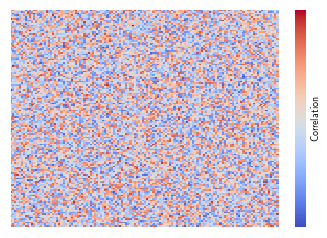

In [139]:
fig, ax = plt.subplots(1)
p = sns.heatmap(dt3,
                cmap='coolwarm',
                annot=False,
#                 fmt=".1f",
#                 annot_kws={'size':16},
                cbar_kws={'ticks':[],
                          'label':'Correlation'},
                ax=ax,
                xticklabels='',
                yticklabels='')
#                 vmax = 0.08,
#                 vmin=-0.08)
plt.xlabel('')
plt.ylabel('')

Text(50.0, 0.5, '')

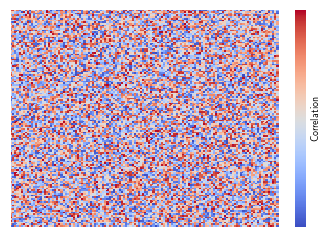

In [144]:
fig, ax = plt.subplots(1)
p = sns.heatmap(images[0,:,:].numpy(),
                cmap='coolwarm',
                annot=False,
#                 fmt=".1f",
#                 annot_kws={'size':16},
                cbar_kws={'ticks':[],
                          'label':'Correlation'},
                ax=ax,
                xticklabels='',
                yticklabels='')
#                 vmax = 0.08,
#                 vmin=-0.08)
plt.xlabel('')
plt.ylabel('')

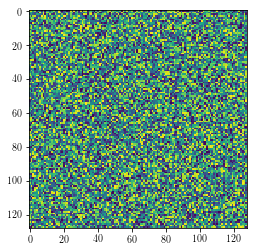

In [145]:
plt.imshow(images[0,:,:])